# Experimental Validation

KARATE CLUB

In [ ]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )
  
    X_train,y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
  
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
 
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [ ]:
from networkx import to_numpy_array

In [ ]:
import torch
zkc = load_karate_club()
X_train = zkc.X_train.flatten()
X_test= zkc.X_test.flatten()
y_train = zkc.y_train
y_test = zkc.y_test
print(y_train)
A=to_numpy_array(zkc.network)
#A = to_numpy_matrix(zkc.network)
#A = torch.from_numpy(np.array(A,dtype=object))
print(A)
print(X_train)

[ True False]
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[ 0 33]


In [ ]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
from networkx import degree_centrality, betweenness_centrality, shortest_path_length,to_numpy_array
import mxnet.ndarray as nd



Viewing the graph:

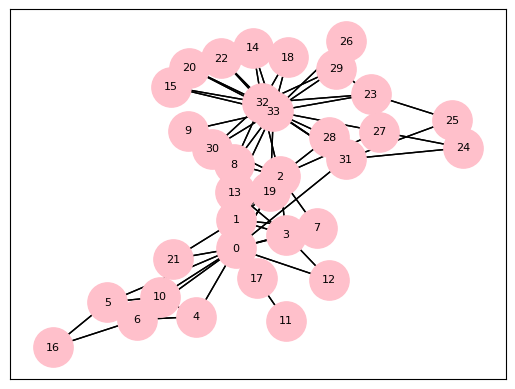

In [ ]:
import networkx as nx
pos = nx.fruchterman_reingold_layout(zkc.network)
nx.draw_networkx(zkc.network, pos=pos, node_size = 800, font_size=8, node_color="pink")
nx.draw_networkx_edges(zkc.network, pos=pos)
edge_labels = nx.get_edge_attributes(zkc.network, 'weight')
nx.draw_networkx_edge_labels(zkc.network, pos=pos, edge_labels=edge_labels)
plt.show()

In [ ]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [ ]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

In [ ]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

In [ ]:
import mxnet
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(nd.array(A), X_1)
#model_1(X_1)

In [ ]:
list1 = []

In [ ]:

%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]
            

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        list1.append(cum_loss)
        
        print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [ ]:
from sklearn.metrics import classification_report

model_3, features_3 = build_model(nd.array(A), X_1)
model_3(X_1)
feature_representations_3= train(model_3, features_3, X_1, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_1, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 1/1000 -- Loss:  1.4895
[0.35669667, 0.36787733]
Epoch 2/1000 -- Loss:  1.4894
[0.35690755, 0.3681525]
Epoch 3/1000 -- Loss:  1.4891
[0.35724485, 0.3685531]
Epoch 4/1000 -- Loss:  1.4886
[0.3577084, 0.36907908]
Epoch 5/1000 -- Loss:  1.4880
[0.35829806, 0.36973003]
Epoch 6/1000 -- Loss:  1.4872
[0.35901353, 0.37050572]
Epoch 7/1000 -- Loss:  1.4863
[0.3598544, 0.3714056]
Epoch 8/1000 -- Loss:  1.4853
[0.36082038, 0.3724293]
Epoch 9/1000 -- Loss:  1.4841
[0.36191103, 0.37357622]
Epoch 10/1000 -- Loss:  1.4828
[0.36312565, 0.3748458]
Epoch 11/1000 -- Loss:  1.4813
[0.3644638, 0.37623724]
Epoch 12/1000 -- Loss:  1.4797
[0.36592475, 0.37774983]
Epoch 13/1000 -- Loss:  1.4781
[0.3675077, 0.3793826]
Epoch 14/1000 -- Loss:  1.4763
[0.36921188, 0.38113463]
Epoch 15/1000 -- Loss:  1.4743
[0.3710363, 0.3830048]
Epoch 16/1000 -- Loss:  1.4724
[0.37297994, 0.38499197]
Epoch 17/1000 -- Loss:  1.4703
[0.3750416, 0.38709486]
Epoch 18/1000 -- Loss:  1.4681
[0.37722015, 0.38931206]
Epoch 19/1000 

In [ ]:
def multi_plot(y,n,name):
    epoch_list = [i for i in range(n)]
    for i,l in y:
        plt.plot(epoch_list, i, label=l)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    leg = plt.legend(loc='lower right')
    plt.title(name)

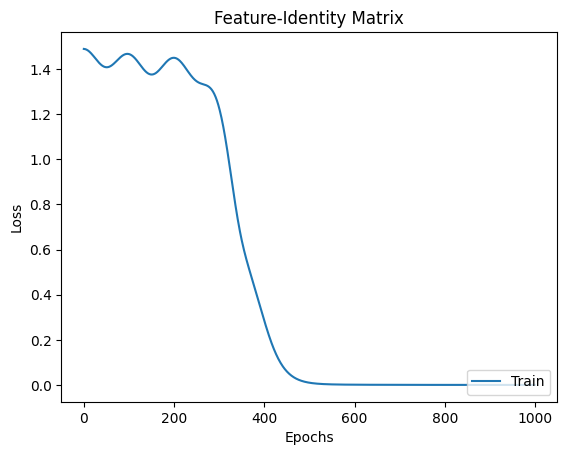

In [ ]:
multi_plot([(list1 ,'Train')],100,'Feature-Identity Matrix')

In [ ]:
cycle3_1 = []

for i in range(0,34):
  for j in range(0,34):
    if(A[i][j]>0): #if edge exists
      for k in range(0,34):
        if(i!=k and A[j][k]>0 and A[k][i]>0):  #if other two edges exist
          if([i,j,k] not in cycle3_1 and [j,i,k] not in cycle3_1 and [k,i,j] not in cycle3_1 and [i,k,j] not in cycle3_1 and [j,k,i] not in cycle3_1 and [k,j,i] not in cycle3_1):
            cycle3_1.append([i,j,k])
            #print(characters[i],characters[j],characters[k]);

In [ ]:
cycle3_1

[[0, 1, 2],
 [0, 1, 3],
 [0, 1, 7],
 [0, 1, 12],
 [0, 1, 13],
 [0, 1, 14],
 [0, 1, 15],
 [0, 2, 3],
 [0, 2, 7],
 [0, 2, 8],
 [0, 2, 12],
 [0, 3, 7],
 [0, 3, 11],
 [0, 3, 12],
 [0, 4, 6],
 [0, 4, 9],
 [0, 5, 6],
 [0, 5, 9],
 [1, 2, 3],
 [1, 2, 7],
 [1, 2, 12],
 [1, 3, 7],
 [1, 3, 12],
 [2, 3, 7],
 [2, 3, 12],
 [2, 8, 21],
 [5, 6, 22],
 [8, 17, 21],
 [8, 17, 23],
 [8, 21, 23],
 [16, 20, 23],
 [16, 21, 23],
 [16, 30, 32],
 [17, 21, 23],
 [19, 23, 29],
 [21, 23, 24],
 [21, 23, 25],
 [21, 23, 26],
 [21, 23, 27],
 [21, 23, 28],
 [21, 23, 29],
 [21, 23, 31],
 [21, 29, 31],
 [23, 29, 31],
 [23, 31, 33]]

In [ ]:
cycle6_1 = []

for i in range(0,34):
  for j in range(0,34):
    if(A[i][j]>0): #edge btw i and j
      for k in range(0,34):
        if(i!=k and A[j][k]>0): #edge btw j and k
          for l in range(0,34):
            if(i!=l and j!=l and A[k][l]>0): #edge between l and k
              for m in range(0,34):
                if(i!=m and j!=m and k!=m and A[l][m]>0): #edge between l and m
                  for n in range(0,34):
                    if(i!=n and j!=n and k!=n and l!=n and A[m][n]>0 and A[n][i]>0): #edge between m and n and edge btw n and i to complete the cycle
                      whatever = []
                      whatever.append(i)
                      whatever.append(j)
                      whatever.append(k)
                      whatever.append(l)
                      whatever.append(m)
                      whatever.append(n)
                      whatever.sort()
                      if(whatever not in cycle6_1):
                        cycle6_1.append(whatever)

                      # print(characters[i],characters[j],characters[k],characters[l],characters[m],characters[n])
                  

In [ ]:
X_3 = nd.zeros((A.shape[0], 2))
for i in cycle3_1:
  for node in i:
     X_3[node][0]+=1
for i in cycle6_1:
  for node in i:
     X_3[node][1]+=1

In [ ]:
#X_3 = nd.concat(X_1,X_2,X_3)
X_4=nd.concat(X_1,X_3)
model_3, features_3 = build_model(nd.array(A), X_4)
model_3(X_4)

In [ ]:
list2 = []

In [ ]:
def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]
            

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        list2.append(cum_loss)
        
        print(cum_preds)
    return feature_representations

In [ ]:
feature_representations_3= train(model_3, features_3, X_4, X_train, y_train, epochs=1000)
y_pred_3 = predict(model_3, X_4, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 1/1000 -- Loss:  1.4696
[0.43560728, 0.4719354]
Epoch 2/1000 -- Loss:  1.4694
[0.43576443, 0.47206056]
Epoch 3/1000 -- Loss:  1.4692
[0.43595433, 0.4721601]
Epoch 4/1000 -- Loss:  1.4688
[0.4361768, 0.4722339]
Epoch 5/1000 -- Loss:  1.4683
[0.43643177, 0.47228208]
Epoch 6/1000 -- Loss:  1.4677
[0.43671915, 0.4723046]
Epoch 7/1000 -- Loss:  1.4670
[0.43703878, 0.47230175]
Epoch 8/1000 -- Loss:  1.4661
[0.43739063, 0.47227377]
Epoch 9/1000 -- Loss:  1.4651
[0.43777466, 0.472221]
Epoch 10/1000 -- Loss:  1.4640
[0.4381907, 0.47214374]
Epoch 11/1000 -- Loss:  1.4628
[0.43863884, 0.47204268]
Epoch 12/1000 -- Loss:  1.4615
[0.43911892, 0.47191817]
Epoch 13/1000 -- Loss:  1.4600
[0.43963093, 0.47177103]
Epoch 14/1000 -- Loss:  1.4585
[0.44017497, 0.47160193]
Epoch 15/1000 -- Loss:  1.4568
[0.44075084, 0.47141173]
Epoch 16/1000 -- Loss:  1.4550
[0.4413587, 0.4712014]
Epoch 17/1000 -- Loss:  1.4532
[0.4419984, 0.4709719]
Epoch 18/1000 -- Loss:  1.4512
[0.44267005, 0.47072434]
Epoch 19/1000

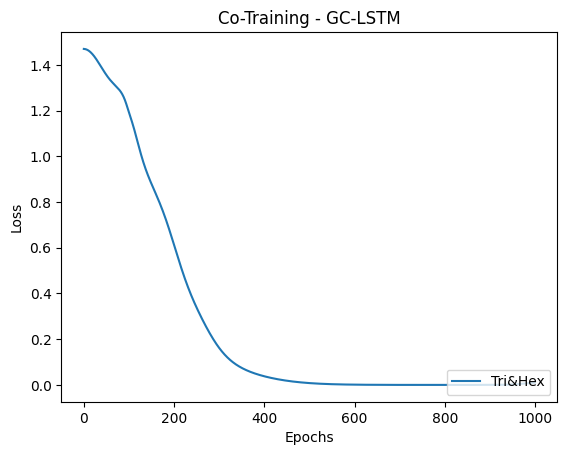

In [ ]:
multi_plot([(list2,'Tri&Hex')],1000,'Co-Training - GC-LSTM')

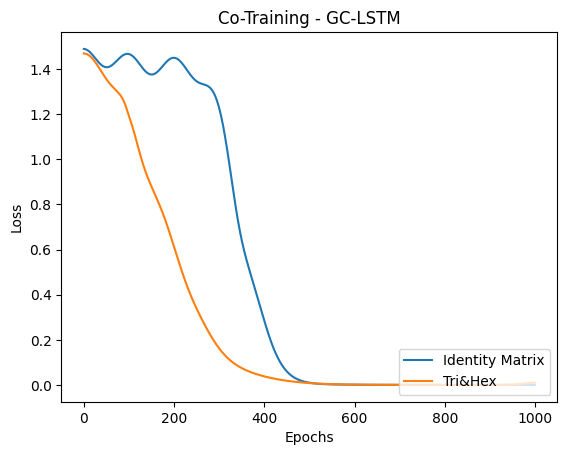

In [ ]:
multi_plot([(list1 ,'Identity Matrix'),(list2,'Tri&Hex')],1000,'Co-Training - GC-LSTM')

In [ ]:
X_7 = nd.zeros((A.shape[0], 1))
for i in cycle3_1:
  for node in i:
     X_7[node][0]+=1
X_8 = nd.zeros((A.shape[0], 1))
for i in cycle6_1:
  for node in i:
     X_8[node][0]+=1

In [ ]:
list3 = []

In [ ]:
def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]
            

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        list3.append(cum_loss)
        
        print(cum_preds)
    return feature_representations

In [ ]:
X_7=nd.concat(X_1,X_7)
model_3, features_3 = build_model(nd.array(A), X_7)
print(model_3(X_7))
feature_representations_3= train(model_3, features_3, X_7, X_train, y_train, epochs=1000)
y_pred_3 = predict(model_3, X_7, X_test)
print(classification_report(y_test, y_pred_3))


[[0.68714714]
 [0.6798681 ]
 [0.68434757]
 [0.66979045]
 [0.68088055]
 [0.6756383 ]
 [0.671672  ]
 [0.6610795 ]
 [0.68177277]
 [0.6913913 ]
 [0.6451381 ]
 [0.68713576]
 [0.6726956 ]
 [0.69070035]
 [0.6933164 ]
 [0.6702236 ]
 [0.68833035]
 [0.68238693]
 [0.6764573 ]
 [0.6900339 ]
 [0.6909201 ]
 [0.6843516 ]
 [0.6848383 ]
 [0.6891961 ]
 [0.6712452 ]
 [0.6999141 ]
 [0.66517675]
 [0.70256114]
 [0.6751022 ]
 [0.68046296]
 [0.68845904]
 [0.6795978 ]
 [0.6882021 ]
 [0.7026418 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/1000 -- Loss:  1.5882
[0.68714714, 0.7027074]
Epoch 2/1000 -- Loss:  1.5879
[0.6871309, 0.7026007]
Epoch 3/1000 -- Loss:  1.5872
[0.6869468, 0.7023217]
Epoch 4/1000 -- Loss:  1.5862
[0.68659484, 0.7018704]
Epoch 5/1000 -- Loss:  1.5849
[0.68607503, 0.7012466]
Epoch 6/1000 -- Loss:  1.5832
[0.6853874, 0.7004504]
Epoch 7/1000 -- Loss:  1.5813
[0.68453187, 0.6994817]
Epoch 8/1000 -- Loss:  1.5790
[0.68350846, 0.6983404]
Epoch 9/1000 -- Loss:  1.5764
[0.68231744, 0.6970265]
Epoch 10/1000 --

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


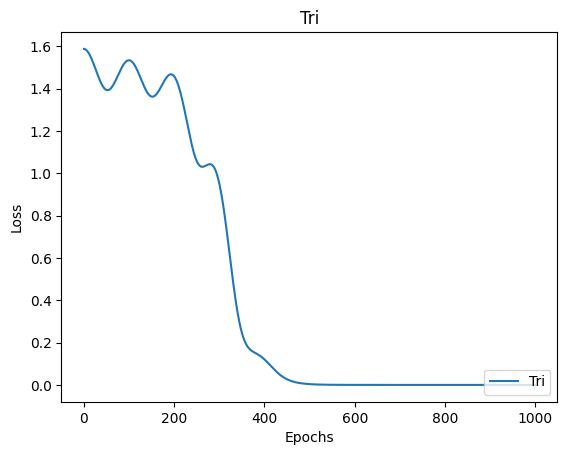

In [ ]:
multi_plot([(list3 ,'Tri')],1000,'Tri')

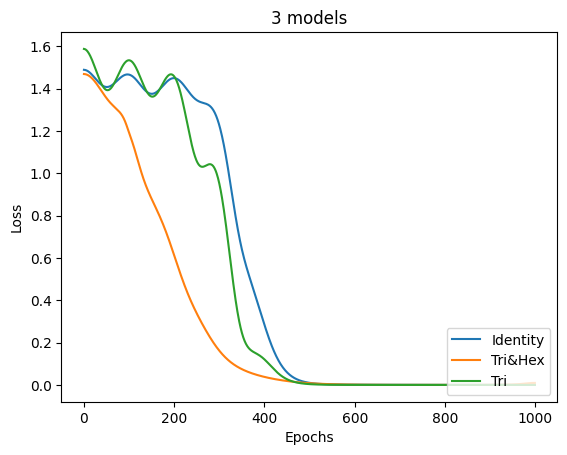

In [ ]:
multi_plot([(list1 ,'Identity'),(list2 ,'Tri&Hex'),(list3 ,'Tri')],1000,'3 models')

In [ ]:
list4 = []

In [ ]:
def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]
            

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        list4.append(cum_loss)
        
        print(cum_preds)
    return feature_representations

In [ ]:
X_8=nd.concat(X_1,X_8)
model_3, features_3 = build_model(nd.array(A), X_8)
print(model_3(X_8))
feature_representations_3= train(model_3, features_3, X_8, X_train, y_train, epochs=1000)
y_pred_3 = predict(model_3, X_8, X_test)
print(classification_report(y_test, y_pred_3))


[[0.71549016]
 [0.7146451 ]
 [0.7143821 ]
 [0.71491206]
 [0.7179649 ]
 [0.71713984]
 [0.7176962 ]
 [0.7151713 ]
 [0.71271694]
 [0.7150055 ]
 [0.7235196 ]
 [0.7152944 ]
 [0.7128415 ]
 [0.7155316 ]
 [0.7115238 ]
 [0.71947354]
 [0.7135072 ]
 [0.7124424 ]
 [0.71226835]
 [0.7131647 ]
 [0.71286374]
 [0.71497464]
 [0.7170857 ]
 [0.7153249 ]
 [0.7197515 ]
 [0.7172127 ]
 [0.71476376]
 [0.7153477 ]
 [0.7182933 ]
 [0.7146552 ]
 [0.71668106]
 [0.7150532 ]
 [0.7165947 ]
 [0.719202  ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/1000 -- Loss:  1.6051
[0.71549016, 0.7192646]
Epoch 2/1000 -- Loss:  1.6044
[0.71544904, 0.7190501]
Epoch 3/1000 -- Loss:  1.6030
[0.71520716, 0.7185581]
Epoch 4/1000 -- Loss:  1.6009
[0.71476495, 0.71778816]
Epoch 5/1000 -- Loss:  1.5981
[0.7141232, 0.7167397]
Epoch 6/1000 -- Loss:  1.5946
[0.713283, 0.715412]
Epoch 7/1000 -- Loss:  1.5904
[0.71224546, 0.71380407]
Epoch 8/1000 -- Loss:  1.5856
[0.7110121, 0.7119147]
Epoch 9/1000 -- Loss:  1.5801
[0.70958436, 0.70974296]
Epoch 10/1000 -

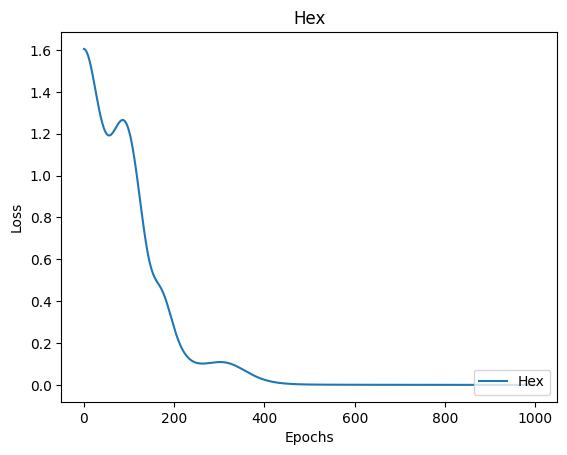

In [ ]:
multi_plot([(list4 ,'Hex')],1000,'Hex')

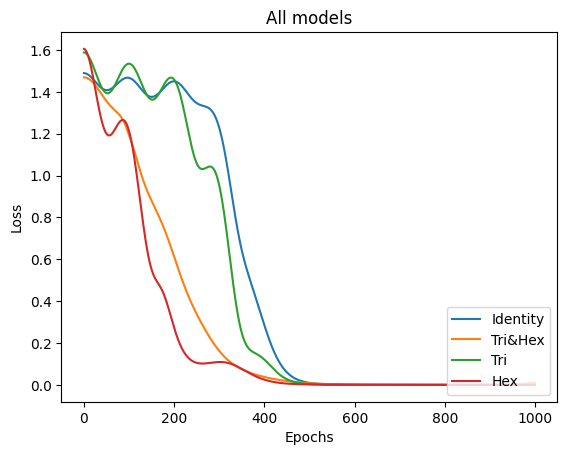

In [ ]:
multi_plot([(list1 ,'Identity'),(list2 ,'Tri&Hex'),(list3 ,'Tri'),(list4 ,'Hex')],1000,'All models')